In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

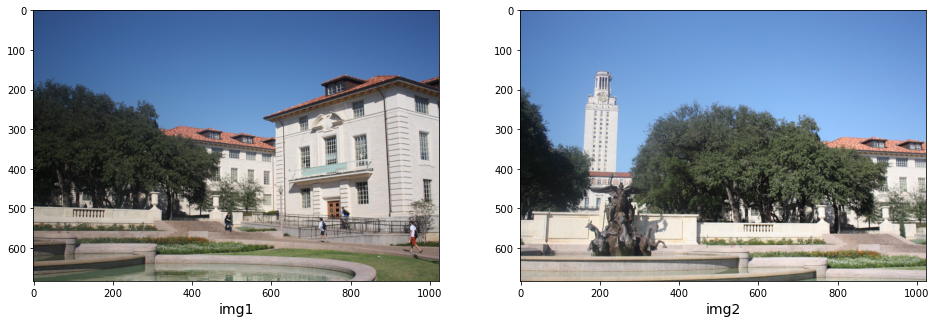

In [15]:
img1 = imageio.imread('A1.JPG')
img2 = imageio.imread('A2.JPG')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(img1, cmap="gray")
ax1.set_xlabel("img1", fontsize=14)

ax2.imshow(img2, cmap="gray")
ax2.set_xlabel("img2", fontsize=14)

plt.show()

In [22]:
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)


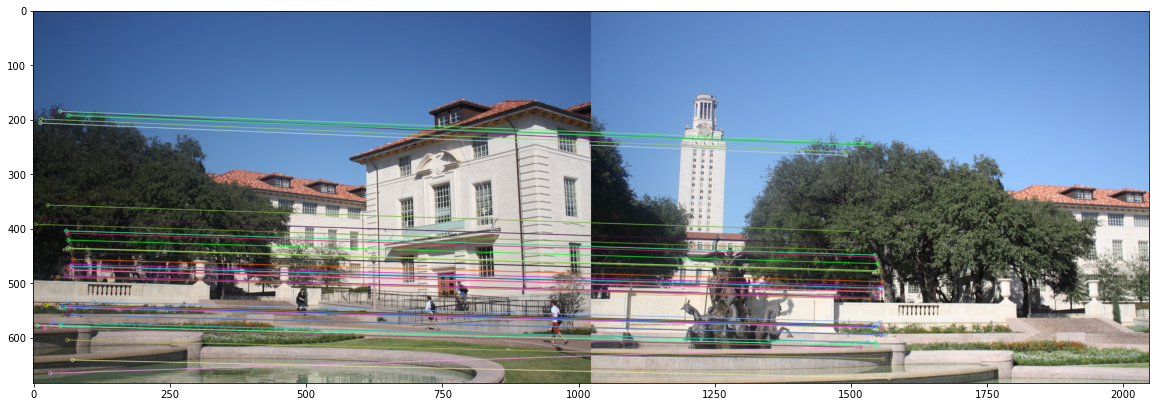

In [20]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_1,descriptors_2, k=2)
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, good[:50], None, flags=2)

plt.figure(figsize=(20,10))
plt.imshow(img3)
plt.show()

In [21]:
def getHomography(kpsA, kpsB, matches, reprojThresh):
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])

    if len(matches) > 4:

        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
                                         reprojThresh)

        return (matches, H, status)
    else:
        return None

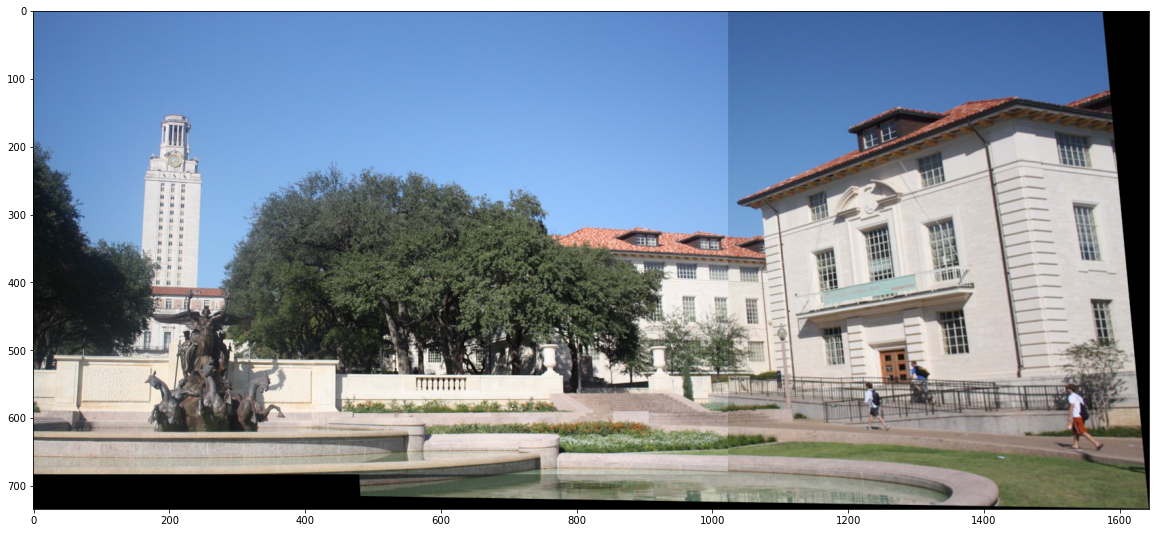

In [23]:
M = getHomography(keypoints_1, keypoints_2, good, reprojThresh=4)

(matches, H, status) = M


width = img1.shape[1] + img2.shape[1]
height = img1.shape[0] + img2.shape[0]

result = cv2.warpPerspective(img1, H, (width, height))
result[0:img2.shape[0], 0:img2.shape[1]] = img2

gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

c = max(cnts, key=cv2.contourArea)

(x, y, w, h) = cv2.boundingRect(c)

result = result[y:y + h, x:x + w]
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()